Computing metrics for all variables, scenarios, and models...

PR:
  historical... Done
  ssp126... Done
  ssp245... Done
  ssp585... Done

TAS:
  historical... Done
  ssp126... Done
  ssp245... Done
  ssp585... Done

HURS:
  historical... Done
  ssp126... Done
  ssp245... Done
  ssp585... Done

SFCWIND:
  historical... Done
  ssp126... Done
  ssp245... Done
  ssp585... Done

All metrics computed!

Creating visualization...


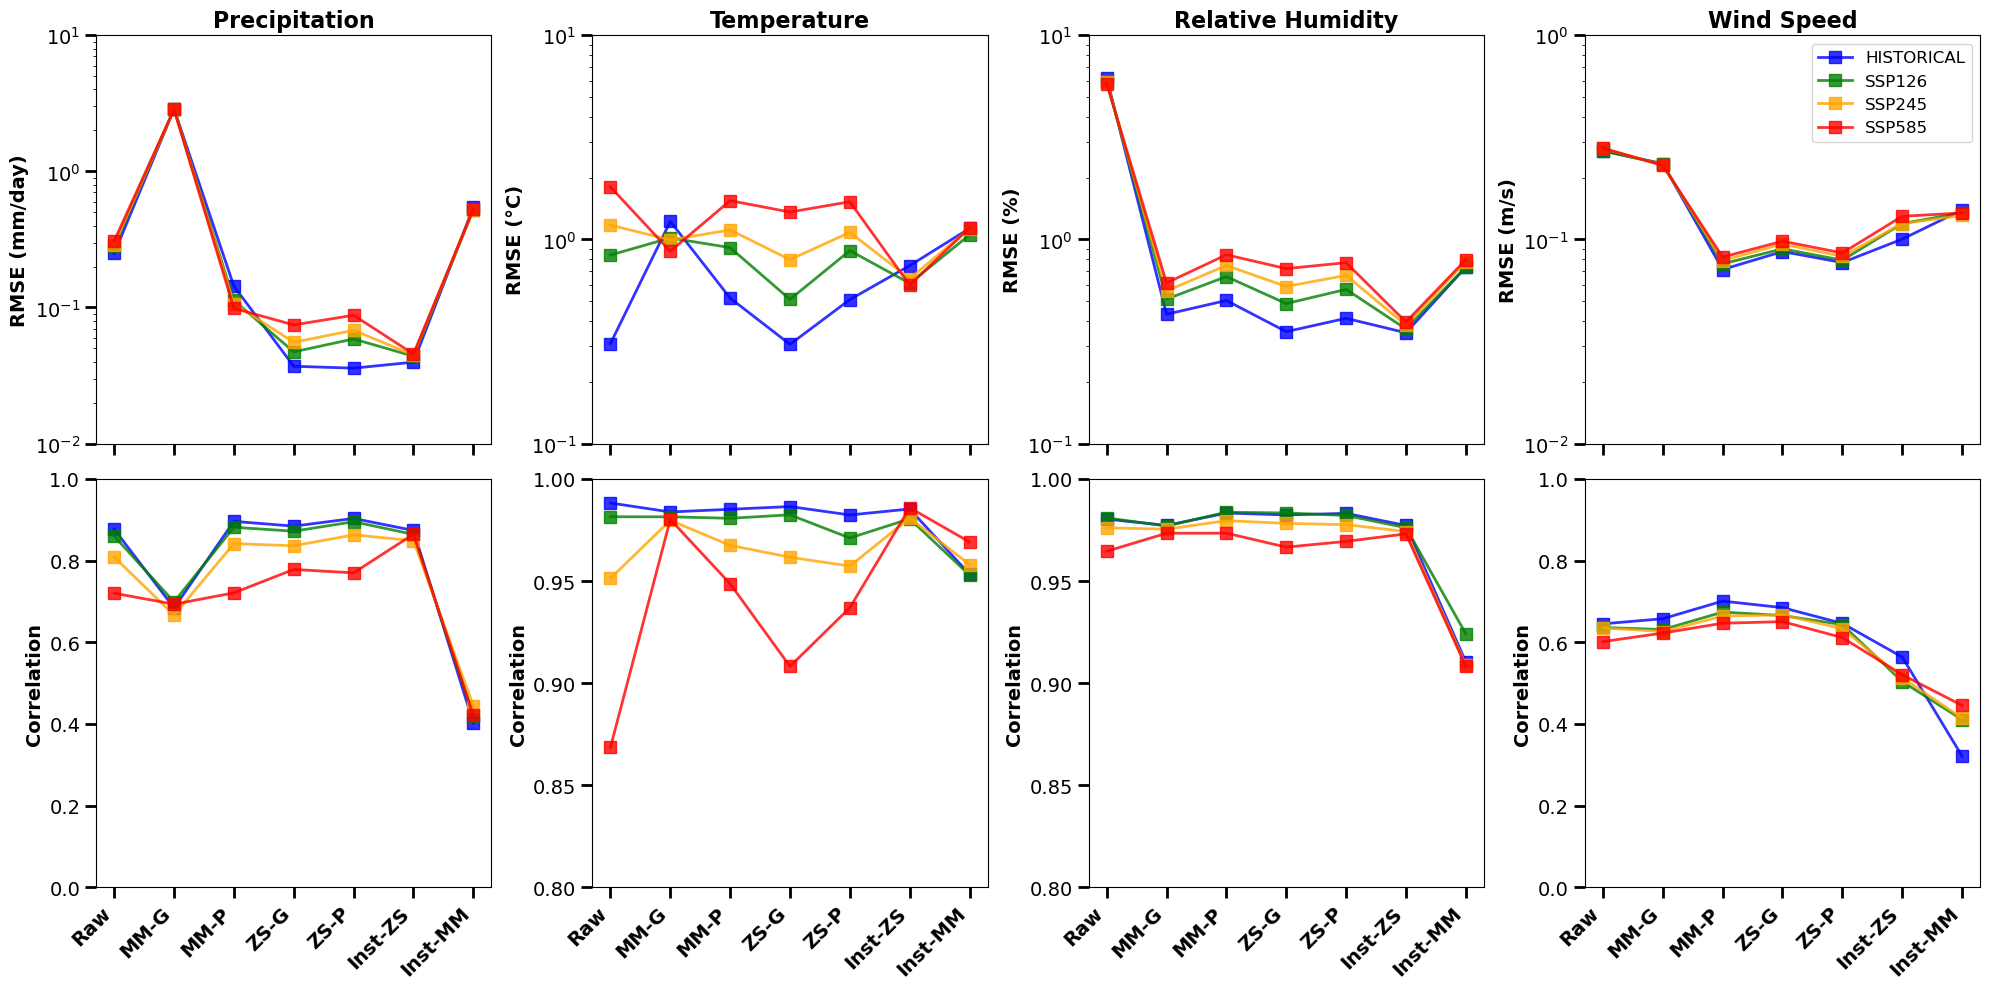

In [7]:
# analyze_global_timeseries.py

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("evaluation_results")
variables = ['pr', 'tas', 'hurs', 'sfcWind']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']
normalizations = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                  'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Normalization labels for plotting
norm_labels = {
    'none': 'Raw',
    'minmax_global': 'MM-G',
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS',
    'instance_minmax': 'Inst-MM'
}

# Variable names for titles
var_names = {
    'pr': 'Precipitation',
    'tas': 'Temperature',
    'hurs': 'Relative Humidity',
    'sfcWind': 'Wind Speed'
}

# Y-axis limits
rmse_ylims = {
    'pr': (1e-2, 1e1),
    'tas': (1e-1, 1e1),
    'hurs': (1e-1, 1e1),
    'sfcWind': (1e-2, 1e0)
}

corr_ylims = {
    'pr': (0, 1),
    'tas': (0.8, 1),
    'hurs': (0.8, 1),
    'sfcWind': (0, 1)
}

# Correlation y-axis ticks
corr_yticks = {
    'pr': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
    'tas': [0.80, 0.85, 0.90, 0.95, 1.0],
    'hurs': [0.80, 0.85, 0.90, 0.95, 1.0],
    'sfcWind': [0, 0.2, 0.4, 0.6, 0.8, 1.0]
}

# Units for RMSE
rmse_units = {
    'pr': 'mm/day',
    'tas': '°C',
    'hurs': '%',
    'sfcWind': 'm/s'
}

# ----------------------------
# Functions
# ----------------------------
def compute_spatial_mean(data):
    """Compute spatial average to get 1D time series."""
    return data.mean(dim=['lat', 'lon']).values

def compute_metrics(y_true, y_pred):
    """Compute RMSE and Pearson correlation."""
    # RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    
    # Pearson correlation
    corr, _ = pearsonr(y_true, y_pred)
    
    return rmse, corr

# ----------------------------
# Compute all metrics
# ----------------------------
print("Computing metrics for all variables, scenarios, and models...")
print("="*80)

# Storage: metrics[variable][scenario][normalization] = (rmse, corr)
metrics = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    print(f"\n{var.upper()}:")
    
    for scenario in scenarios:
        print(f"  {scenario}...", end=" ")
        
        # Load evaluation results
        results_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        ds = xr.open_dataset(results_file)
        
        # Get ground truth spatial mean
        gt_spatial_mean = compute_spatial_mean(ds['groundtruth'])
        
        # Evaluate each normalization method
        for norm in normalizations:
            pred_key = f'pred_{norm}'
            
            if pred_key not in ds:
                print(f"\n    Warning: {pred_key} not found")
                continue
            
            # Get prediction spatial mean
            pred_spatial_mean = compute_spatial_mean(ds[pred_key])
            
            # Compute metrics
            rmse, corr = compute_metrics(gt_spatial_mean, pred_spatial_mean)
            metrics[var][scenario][norm] = (rmse, corr)
        
        print("Done")

print("\n" + "="*80)
print("All metrics computed!")

# ----------------------------
# Create visualization
# ----------------------------
print("\nCreating visualization...")

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
scenario_colors = {
    'historical': 'blue',
    'ssp126': 'green',
    'ssp245': 'orange',
    'ssp585': 'red'
}

for row_idx in range(2):
    for col_idx, var in enumerate(variables):
        ax = axes[row_idx, col_idx]
        
        # Prepare data for plotting
        x_positions = np.arange(len(normalizations))
        
        for scenario in scenarios:
            y_values = []
            
            for norm in normalizations:
                if norm in metrics[var][scenario]:
                    rmse, corr = metrics[var][scenario][norm]
                    if row_idx == 0:  # RMSE
                        y_values.append(rmse)
                    else:  # Correlation
                        y_values.append(corr)
                else:
                    y_values.append(np.nan)
            
            # Plot line with square markers
            ax.plot(x_positions, y_values, 
                   marker='s', markersize=8, 
                   label=scenario.upper(), 
                   color=scenario_colors[scenario],
                   linewidth=2, alpha=0.8)
        
        # Set y-axis limits and scale
        if row_idx == 0:  # RMSE
            ax.set_yscale('log')
            ax.set_ylim(rmse_ylims[var])
            ax.set_ylabel(f'RMSE ({rmse_units[var]})', fontsize=14, fontweight='bold')
        else:  # Correlation
            ax.set_ylim(corr_ylims[var])
            ax.set_yticks(corr_yticks[var])
            ax.set_ylabel('Correlation', fontsize=14, fontweight='bold')
        
        # Formatting with clean labels
        ax.set_xticks(x_positions)
        ax.set_xticklabels([norm_labels[norm] for norm in normalizations], 
                          rotation=45, ha='right', fontsize=12, fontweight='bold')
        
        # Increase tick size (length and width) and y-axis tick label size
        ax.tick_params(axis='both', which='major', labelsize=14, 
                      length=8, width=2)
        
        # Title only on top row - use full names
        if row_idx == 0:
            ax.set_title(var_names[var], fontsize=16, fontweight='bold')
        
        # Legend only on top-right subplot
        if row_idx == 0 and col_idx == 3:
            ax.legend(loc='best', fontsize=12)
        
        # Remove x-labels except bottom row
        if row_idx == 0:
            ax.set_xticklabels([])

plt.tight_layout()
